# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
from torchvision.transforms import ToTensor
from albumentations.pytorch import ToTensorV2
import cv2

In [ ]:
from models import *
from utils import *

# Data Transformations

In [3]:
!pip install albumentations

In [4]:
#Transfer the code to utils file

# class AlbumentationsDataset(datasets.CIFAR10):
#     def __init__(self, root="~/data", train=True, download=True, transform=None):

#         super().__init__(root=root, train=train, download=download, transform=transform)

#     def __getitem__(self, index):
#         image,label = self.data[index],self.targets[index]
#         if self.transform is not None:

#             augmented = self.transform(image=image)

#             image = augmented["image"]

#         return image, label


In [5]:
#Transfer the code to utils file

# # Train Phase transformations
# train_transforms = A.Compose([
#         A.HorizontalFlip(),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
#         A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), always_apply=False, p=0.5),
#         A.Resize(32, 32),
#         A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
#         ToTensorV2(),
# ])

# # Test Phase transformations
# test_transforms = A.Compose([
#         A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
#         ToTensorV2(),
# ])

# Dataset and Creating Train/Test Split

In [6]:
# Download and load the CIFAR-10 training dataset
train = AlbumentationsDataset(root='./data', train=True,download=True, transform=train_transforms)
test = AlbumentationsDataset(root='./data', train=False,download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 12240356.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders

In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

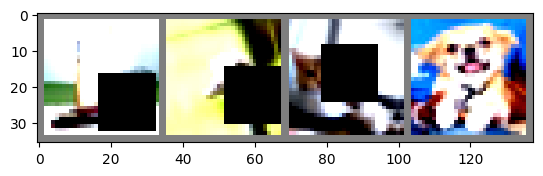

ship  bird  cat   dog  


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# The model

In [33]:
#Transfer the code to models file

# import torch.nn.functional as F

# dropout_value = 0.1

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()

#         ## Convolution Block 1
#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(dropout_value)
#         )  # output_size = 32/3/1

#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Dropout(dropout_value)
#         )  # output_size = 32/5/1

#         ## Transition Block 1
#         self.convblock3 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding = 1, stride = 2, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Dropout(dropout_value)
#         )  # output_size = 17/7/2


#         ## Convolution Block 2
#         self.convblock4 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Dropout(dropout_value)
#         )  # output_size = 17/11/2

#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(dropout_value)
#         )  # output_size = 17/15/2

#         ## Transition Block 2
#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1, stride = 2, bias=False),
#         ) # output_size = 9/19/4

#         ## Convolution Block 3
#         self.convblock7 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(dropout_value)
#         )  # output_size = 9/27/4

#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Dropout(dropout_value)
#         )  # output_size = 9/35/4

#         self.convblock9 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Dropout(dropout_value)
#         )  # output_size = 7/43/4



#         self.gap = nn.Sequential(
#             nn.AvgPool2d(kernel_size=6)
#         )  # output_size = 4/63/4

#         self.convblock10 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#         ) # output_size = 6/63/4

#         self.dropout = nn.Dropout(dropout_value)




#     def forward(self, x):
#         x = self.convblock1(x)
#         x = self.convblock2(x)
#         x = self.convblock3(x)
#         x = self.convblock4(x)
#         x = self.convblock5(x)
#         x = self.convblock6(x)
#         x = self.convblock7(x)
#         x = self.convblock8(x)
#         x = self.convblock9(x)
#         x = self.gap(x)
#         x = self.convblock10(x)
#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)


# Model Params

In [34]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3,32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 16, 16]          36,864
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
          Dropout-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,864
             ReLU-14           [-1

# Training and Testing

In [35]:
#Transfer the code to utils file




# from tqdm import tqdm

# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

# def train(model, device, train_loader, optimizer, epoch):
#   model.train()
#   pbar = tqdm(train_loader)
#   correct = 0
#   processed = 0
#   for batch_idx, (data, target) in enumerate(pbar):
#     # get samples
#     data, target = data.to(device), target.to(device)

#     # Init
#     optimizer.zero_grad()
#     # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
#     # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

#     # Predict
#     y_pred = model(data)

#     # Calculate loss
#     loss = F.nll_loss(y_pred, target)
#     train_losses.append(loss)

#     # Backpropagation
#     loss.backward()
#     optimizer.step()

#     # Update pbar-tqdm

#     pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#     correct += pred.eq(target.view_as(pred)).sum().item()
#     processed += len(data)

#     pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
#     train_acc.append(100*correct/processed)

# def test(model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)
#     test_losses.append(test_loss)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

#     test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [36]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 51
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.5916577577590942 Batch_id=97 Accuracy=32.06: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 1.5153, Accuracy: 4369/10000 (43.69%)

EPOCH: 1


Loss=1.4094793796539307 Batch_id=97 Accuracy=45.73: 100%|██████████| 98/98 [00:17<00:00,  5.59it/s]



Test set: Average loss: 1.3394, Accuracy: 5118/10000 (51.18%)

EPOCH: 2


Loss=1.3519806861877441 Batch_id=97 Accuracy=51.59: 100%|██████████| 98/98 [00:17<00:00,  5.59it/s]



Test set: Average loss: 1.1883, Accuracy: 5774/10000 (57.74%)

EPOCH: 3


Loss=1.2205482721328735 Batch_id=97 Accuracy=55.92: 100%|██████████| 98/98 [00:17<00:00,  5.63it/s]



Test set: Average loss: 1.0986, Accuracy: 6047/10000 (60.47%)

EPOCH: 4


Loss=1.052418828010559 Batch_id=97 Accuracy=58.45: 100%|██████████| 98/98 [00:17<00:00,  5.68it/s]



Test set: Average loss: 0.9712, Accuracy: 6506/10000 (65.06%)

EPOCH: 5


Loss=1.0305101871490479 Batch_id=97 Accuracy=60.58: 100%|██████████| 98/98 [00:18<00:00,  5.19it/s]



Test set: Average loss: 0.9003, Accuracy: 6775/10000 (67.75%)

EPOCH: 6


Loss=0.9918398261070251 Batch_id=97 Accuracy=63.63: 100%|██████████| 98/98 [00:16<00:00,  5.79it/s]



Test set: Average loss: 0.8693, Accuracy: 6885/10000 (68.85%)

EPOCH: 7


Loss=0.9603651762008667 Batch_id=97 Accuracy=64.96: 100%|██████████| 98/98 [00:16<00:00,  5.82it/s]



Test set: Average loss: 0.7825, Accuracy: 7214/10000 (72.14%)

EPOCH: 8


Loss=0.877993643283844 Batch_id=97 Accuracy=66.01: 100%|██████████| 98/98 [00:18<00:00,  5.44it/s]



Test set: Average loss: 0.8174, Accuracy: 7134/10000 (71.34%)

EPOCH: 9


Loss=0.8430257439613342 Batch_id=97 Accuracy=67.65: 100%|██████████| 98/98 [00:16<00:00,  5.86it/s]



Test set: Average loss: 0.7439, Accuracy: 7375/10000 (73.75%)

EPOCH: 10


Loss=0.8389859199523926 Batch_id=97 Accuracy=68.41: 100%|██████████| 98/98 [00:16<00:00,  5.77it/s]



Test set: Average loss: 0.7163, Accuracy: 7498/10000 (74.98%)

EPOCH: 11


Loss=0.8640856146812439 Batch_id=97 Accuracy=69.64: 100%|██████████| 98/98 [00:16<00:00,  5.93it/s]



Test set: Average loss: 0.7188, Accuracy: 7480/10000 (74.80%)

EPOCH: 12


Loss=0.8407358527183533 Batch_id=97 Accuracy=70.74: 100%|██████████| 98/98 [00:16<00:00,  5.82it/s]



Test set: Average loss: 0.6576, Accuracy: 7732/10000 (77.32%)

EPOCH: 13


Loss=0.8583756685256958 Batch_id=97 Accuracy=71.26: 100%|██████████| 98/98 [00:16<00:00,  5.86it/s]



Test set: Average loss: 0.6628, Accuracy: 7725/10000 (77.25%)

EPOCH: 14


Loss=0.8122312426567078 Batch_id=97 Accuracy=71.82: 100%|██████████| 98/98 [00:16<00:00,  5.99it/s]



Test set: Average loss: 0.6324, Accuracy: 7825/10000 (78.25%)

EPOCH: 15


Loss=0.7971852421760559 Batch_id=97 Accuracy=72.16: 100%|██████████| 98/98 [00:17<00:00,  5.71it/s]



Test set: Average loss: 0.6260, Accuracy: 7877/10000 (78.77%)

EPOCH: 16


Loss=0.778242290019989 Batch_id=97 Accuracy=73.01: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]



Test set: Average loss: 0.6168, Accuracy: 7892/10000 (78.92%)

EPOCH: 17


Loss=0.7494722604751587 Batch_id=97 Accuracy=73.61: 100%|██████████| 98/98 [00:18<00:00,  5.40it/s]



Test set: Average loss: 0.6057, Accuracy: 7969/10000 (79.69%)

EPOCH: 18


Loss=0.6738333702087402 Batch_id=97 Accuracy=74.26: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]



Test set: Average loss: 0.5699, Accuracy: 8048/10000 (80.48%)

EPOCH: 19


Loss=0.6222792863845825 Batch_id=97 Accuracy=74.65: 100%|██████████| 98/98 [00:16<00:00,  5.93it/s]



Test set: Average loss: 0.5534, Accuracy: 8098/10000 (80.98%)

EPOCH: 20


Loss=0.7610015869140625 Batch_id=97 Accuracy=75.00: 100%|██████████| 98/98 [00:17<00:00,  5.76it/s]



Test set: Average loss: 0.5423, Accuracy: 8158/10000 (81.58%)

EPOCH: 21


Loss=0.7393991947174072 Batch_id=97 Accuracy=75.32: 100%|██████████| 98/98 [00:16<00:00,  5.83it/s]



Test set: Average loss: 0.5424, Accuracy: 8153/10000 (81.53%)

EPOCH: 22


Loss=0.7163697481155396 Batch_id=97 Accuracy=75.76: 100%|██████████| 98/98 [00:17<00:00,  5.59it/s]



Test set: Average loss: 0.5422, Accuracy: 8140/10000 (81.40%)

EPOCH: 23


Loss=0.7200214266777039 Batch_id=97 Accuracy=76.21: 100%|██████████| 98/98 [00:16<00:00,  5.85it/s]



Test set: Average loss: 0.5199, Accuracy: 8230/10000 (82.30%)

EPOCH: 24


Loss=0.6162440180778503 Batch_id=97 Accuracy=76.21: 100%|██████████| 98/98 [00:17<00:00,  5.75it/s]



Test set: Average loss: 0.5311, Accuracy: 8227/10000 (82.27%)

EPOCH: 25


Loss=0.6032843589782715 Batch_id=97 Accuracy=76.33: 100%|██████████| 98/98 [00:16<00:00,  5.83it/s]



Test set: Average loss: 0.5242, Accuracy: 8224/10000 (82.24%)

EPOCH: 26


Loss=0.7289502620697021 Batch_id=97 Accuracy=76.61: 100%|██████████| 98/98 [00:16<00:00,  5.87it/s]



Test set: Average loss: 0.5116, Accuracy: 8243/10000 (82.43%)

EPOCH: 27


Loss=0.5872911810874939 Batch_id=97 Accuracy=76.76: 100%|██████████| 98/98 [00:17<00:00,  5.59it/s]



Test set: Average loss: 0.5000, Accuracy: 8298/10000 (82.98%)

EPOCH: 28


Loss=0.6409846544265747 Batch_id=97 Accuracy=77.01: 100%|██████████| 98/98 [00:16<00:00,  5.96it/s]



Test set: Average loss: 0.4904, Accuracy: 8318/10000 (83.18%)

EPOCH: 29


Loss=0.6686100959777832 Batch_id=97 Accuracy=77.62: 100%|██████████| 98/98 [00:17<00:00,  5.73it/s]



Test set: Average loss: 0.4999, Accuracy: 8309/10000 (83.09%)

EPOCH: 30


Loss=0.6500182151794434 Batch_id=97 Accuracy=77.72: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]



Test set: Average loss: 0.4675, Accuracy: 8424/10000 (84.24%)

EPOCH: 31


Loss=0.6276983618736267 Batch_id=97 Accuracy=78.13: 100%|██████████| 98/98 [00:16<00:00,  5.90it/s]



Test set: Average loss: 0.4780, Accuracy: 8401/10000 (84.01%)

EPOCH: 32


Loss=0.597305417060852 Batch_id=97 Accuracy=78.02: 100%|██████████| 98/98 [00:17<00:00,  5.61it/s]



Test set: Average loss: 0.4863, Accuracy: 8356/10000 (83.56%)

EPOCH: 33


Loss=0.6909043192863464 Batch_id=97 Accuracy=78.33: 100%|██████████| 98/98 [00:17<00:00,  5.71it/s]



Test set: Average loss: 0.4638, Accuracy: 8407/10000 (84.07%)

EPOCH: 34


Loss=0.6396323442459106 Batch_id=97 Accuracy=78.33: 100%|██████████| 98/98 [00:17<00:00,  5.47it/s]



Test set: Average loss: 0.4663, Accuracy: 8420/10000 (84.20%)

EPOCH: 35


Loss=0.6067408323287964 Batch_id=97 Accuracy=78.44: 100%|██████████| 98/98 [00:17<00:00,  5.73it/s]



Test set: Average loss: 0.4687, Accuracy: 8442/10000 (84.42%)

EPOCH: 36


Loss=0.6060372591018677 Batch_id=97 Accuracy=78.97: 100%|██████████| 98/98 [00:18<00:00,  5.35it/s]



Test set: Average loss: 0.4725, Accuracy: 8439/10000 (84.39%)

EPOCH: 37


Loss=0.5475785136222839 Batch_id=97 Accuracy=78.70: 100%|██████████| 98/98 [00:16<00:00,  5.80it/s]



Test set: Average loss: 0.4777, Accuracy: 8396/10000 (83.96%)

EPOCH: 38


Loss=0.6206859946250916 Batch_id=97 Accuracy=79.18: 100%|██████████| 98/98 [00:17<00:00,  5.63it/s]



Test set: Average loss: 0.4471, Accuracy: 8479/10000 (84.79%)

EPOCH: 39


Loss=0.6280375719070435 Batch_id=97 Accuracy=79.28: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]



Test set: Average loss: 0.4462, Accuracy: 8496/10000 (84.96%)

EPOCH: 40


Loss=0.593809187412262 Batch_id=97 Accuracy=79.20: 100%|██████████| 98/98 [00:16<00:00,  5.94it/s]



Test set: Average loss: 0.4444, Accuracy: 8513/10000 (85.13%)

EPOCH: 41


Loss=0.6055455803871155 Batch_id=97 Accuracy=79.56: 100%|██████████| 98/98 [00:16<00:00,  5.86it/s]



Test set: Average loss: 0.4377, Accuracy: 8542/10000 (85.42%)

EPOCH: 42


Loss=0.5883526802062988 Batch_id=97 Accuracy=79.69: 100%|██████████| 98/98 [00:16<00:00,  5.93it/s]



Test set: Average loss: 0.4395, Accuracy: 8542/10000 (85.42%)

EPOCH: 43


Loss=0.5171542167663574 Batch_id=97 Accuracy=79.61: 100%|██████████| 98/98 [00:17<00:00,  5.61it/s]



Test set: Average loss: 0.4324, Accuracy: 8538/10000 (85.38%)

EPOCH: 44


Loss=0.5194998383522034 Batch_id=97 Accuracy=79.75: 100%|██████████| 98/98 [00:17<00:00,  5.76it/s]



Test set: Average loss: 0.4436, Accuracy: 8541/10000 (85.41%)

EPOCH: 45


Loss=0.5743461847305298 Batch_id=97 Accuracy=79.97: 100%|██████████| 98/98 [00:17<00:00,  5.75it/s]



Test set: Average loss: 0.4479, Accuracy: 8487/10000 (84.87%)

EPOCH: 46


Loss=0.5934813618659973 Batch_id=97 Accuracy=80.21: 100%|██████████| 98/98 [00:17<00:00,  5.55it/s]



Test set: Average loss: 0.4194, Accuracy: 8576/10000 (85.76%)

EPOCH: 47


Loss=0.49859583377838135 Batch_id=97 Accuracy=80.28: 100%|██████████| 98/98 [00:16<00:00,  5.81it/s]



Test set: Average loss: 0.4168, Accuracy: 8576/10000 (85.76%)

EPOCH: 48


Loss=0.5965073108673096 Batch_id=97 Accuracy=80.38: 100%|██████████| 98/98 [00:17<00:00,  5.62it/s]



Test set: Average loss: 0.4310, Accuracy: 8560/10000 (85.60%)

EPOCH: 49


Loss=0.5579358339309692 Batch_id=97 Accuracy=80.39: 100%|██████████| 98/98 [00:16<00:00,  5.94it/s]



Test set: Average loss: 0.4205, Accuracy: 8603/10000 (86.03%)

EPOCH: 50


Loss=0.6213216185569763 Batch_id=97 Accuracy=80.44: 100%|██████████| 98/98 [00:17<00:00,  5.67it/s]



Test set: Average loss: 0.4125, Accuracy: 8615/10000 (86.15%)



Text(0.5, 1.0, 'Test Accuracy')

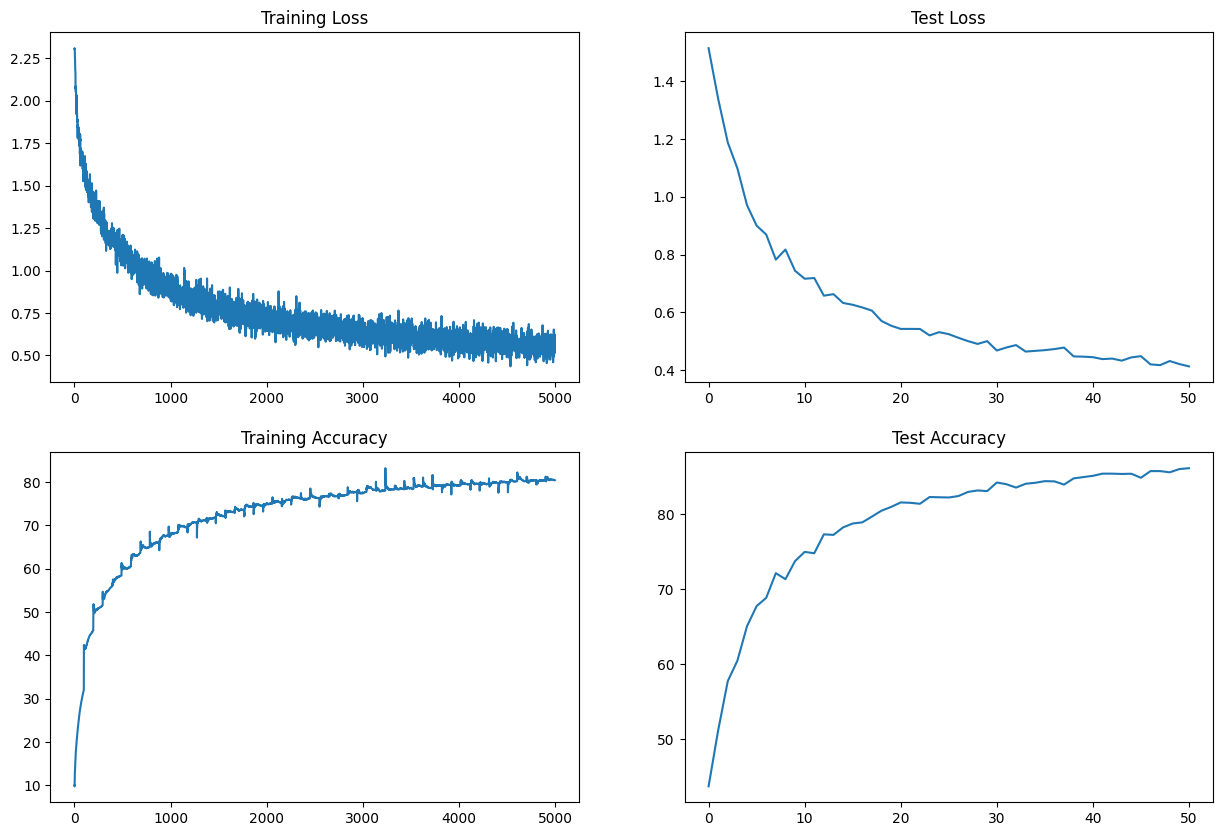

In [37]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target
  1. Make this network:

      a) C1C2C3C40 (No MaxPooling, but 3 3x3 layers with stride of 2 instead)

  2. Total Params to be less than 200k

  3. Use argumentation library and apply:
          a) horizontal flip
          b) shiftScaleRotate
          c) coarseDropout (max_holes = 1, max_height=16px, max_width=1, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)
  4. Achieve 85% accuracy
  5. Total RF must be more than 44
  6. One of the layers must use Depthwise Separable Convolution
  7. One of the layers must use Dilated Convolution

Result
  1. Out Best Training accuracy was 80.44 %
  2. Out Best Testing accuracy was 86.15 %

Analysis
  1. We can still see the underfitting
  2. We have achieved target of getting RF of more then 44
  3. We have achieve our target of accuracy of more then 85
  4. We have achieve our target of making NN without Max Pool and with stride of 2
  5. We have achieve our target of implemeneting argumenetation library
  6. We have failed to implemented dilated layer
  7. We have failed to implemented depth wise layer